# **Vehicle Analysis**

In [88]:

import pandas as pd
import numpy as np
from statistics import mode
import json
from datetime import datetime
import requests
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing 
from sklearn.impute import KNNImputer
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

from dash import Dash, html, dcc, Input, Output,  callback
import plotly.express as px

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## Data extraction

### Vehicle data

In [89]:
veh_data = pd.read_parquet(r"https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/all-vehicles-model/exports/parquet?lang=en&timezone=America%2FGuatemala")

### Vehicle metadata

In [90]:
with open(r"../files/veh_data_schema.json", "r") as f:
    veh_data_schema = json.load(f)
    veh_data_schema = veh_data_schema["definitions"]["all-vehicles-model_records"]["properties"]["fields"]["properties"]
    veh_metadata = pd.DataFrame(veh_data_schema).transpose()[["title","description","type","unit"]] 

In [91]:
new_col_names = {idx.lower():veh_metadata.title[idx].lower().replace(" ","_") for idx in veh_metadata.index}
veh_data.rename(columns = new_col_names, inplace = True)

## Data Cleaning/Wrangling

### Data understanding

In this part of the notebook the goal is to understand as much columns as possible, identifying the right ones that can be used in the model, and take out all the columns that does not have acurate data

In [92]:
veh_metadata

,title,description,type,unit
make,Make,manufacturer (division),string,NaN
model,Model,model name (carline),string,NaN
barrels08,Annual Petroleum Consumption For Fuel Type1,annual petroleum consumption in barrels for fu...,number,NaN
barrelsa08,Annual Petroleum Consumption For Fuel Type2,annual petroleum consumption in barrels for fu...,number,NaN
charge120,Time to charge at 120V,time to charge an electric vehicle in hours at...,number,NaN
charge240,Time to charge at 240V,time to charge an electric vehicle in hours at...,number,NaN
city08,City Mpg For Fuel Type1,city MPG for fuelType1,integer,NaN
city08u,Unrounded City Mpg For Fuel Type1 (2),unrounded city MPG for fuelType1 (2),number,NaN
citya08,City Mpg For Fuel Type2,city MPG for fuelType2,integer,NaN
citya08u,Unrounded City Mpg For Fuel Type2,unrounded city MPG for fuelType2,number,NaN


In this case, we'll analyze and create a model for those vehicles which year is higher or equal to 2000

In [93]:
veh_subdata = veh_data.query("year >= '2000'")[[
                                    "make",
                                    "basemodel",
                                    "model", 
                                    "year", 
                                    "vehicle_size_class",
                                    "cylinders", 
                                    "engine_displacement",# in liters 
                                    "t_charger", # has turbocharger (True/False)
                                    "s_charger", # has supercharger (True/False)
                                    "electric_motor",
                                    "transmission",
                                    "drive", #traction      
                                    "start-stop",
                                    "fuel_type", 
                                    "fuel_type1",
                                    "fuel_type2",
                                    "phev_blended",
                                    #"range_for_fuel_type1", not enough data
                                    #"range_city_for_fuel_type1", not enough data
                                    #"range_highway_for_fuel_type1", not enough data
                                    #"highway_gasoline_consumption",
                                    "city_electricity_consumption", #kWh/100 miles
                                    "city_mpg_for_fuel_type1", # miles per gallon, the mpg equivalent in electricity = 33.705*(kWh/100 miles)**-1  
                                    #"unrounded_city_mpg_for_fuel_type1_(2)",# not enough data
                                    "city_mpg_for_fuel_type2",
                                    #"unadjusted_city_mpg_for_fuel_type2",
                                    "highway_electricity_consumption",
                                    "highway_mpg_for_fuel_type1",
                                    #"unadjusted_highway_mpg_for_fuel_type1",
                                    "highway_mpg_for_fuel_type2",
                                    #"unadjusted_highway_mpg_for_fuel_type2",
                                    "combined_electricity_consumption", # combined means using the car in the city and highway
                                    "combined_mpg_for_fuel_type1",
                                    #"unrounded_combined_mpg_for_fuel_type1",
                                    "combined_mpg_for_fuel_type2", 
                                    #"unrounded_combined_mpg_for_fuel_type2",
                                    "time_to_charge_at_120v",# time in hours
                                    "time_to_charge_at_240v",# time in hours
                                    "co2_tailpipe_for_fuel_type1", # g/mile
                                    "co2_tailpipe_for_fuel_type2" # g/mile
                                    ]]

### Generating/modifying columns

In this section I modify some columns in order to get the International System units in the columns required

#### ***Datatypes***

In [94]:
veh_subdata.dtypes

make                                 object
basemodel                            object
model                                object
year                                 object
vehicle_size_class                   object
cylinders                           float64
engine_displacement                 float64
t_charger                            object
s_charger                            object
electric_motor                       object
transmission                         object
drive                                object
start-stop                           object
fuel_type                            object
fuel_type1                           object
fuel_type2                           object
phev_blended                         object
city_electricity_consumption        float64
city_mpg_for_fuel_type1               int64
city_mpg_for_fuel_type2               int64
highway_electricity_consumption     float64
highway_mpg_for_fuel_type1            int64
highway_mpg_for_fuel_type2      

In [95]:
veh_subdata.phev_blended.value_counts(dropna=False)

phev_blended
false    29263
true       283
Name: count, dtype: int64

In [96]:
veh_subdata.loc[veh_subdata.phev_blended == "false","phev_blended"] = False
veh_subdata.loc[veh_subdata.phev_blended == "true","phev_blended"] = True

In [97]:
veh_subdata.phev_blended.value_counts(dropna=False)
veh_subdata.phev_blended = veh_subdata.phev_blended.astype(bool)

In [98]:
veh_subdata.year = veh_subdata.year.astype(int)

veh_subdata.dtypes

make                                 object
basemodel                            object
model                                object
year                                  int64
vehicle_size_class                   object
cylinders                           float64
engine_displacement                 float64
t_charger                            object
s_charger                            object
electric_motor                       object
transmission                         object
drive                                object
start-stop                           object
fuel_type                            object
fuel_type1                           object
fuel_type2                           object
phev_blended                           bool
city_electricity_consumption        float64
city_mpg_for_fuel_type1               int64
city_mpg_for_fuel_type2               int64
highway_electricity_consumption     float64
highway_mpg_for_fuel_type1            int64
highway_mpg_for_fuel_type2      

#### ***mpg*** (miles per gallon) to ***kmpl*** (km per liter)

- 1 mpg = 0.354006 kmpl

In [99]:
def mpg_to_kmpl(cols:list, df:pd.DataFrame)->pd.DataFrame:
    new_df = df.copy()
    for col in cols:
        new_df[col] = new_df[col]*0.354006 #convertion to km/l = kmpl
        new_col_name = col.replace("mpg","kmpl")
        new_df.rename(columns = {col:new_col_name}, inplace=True)
    return new_df    

In [100]:
mpg_cols = [x for x in veh_subdata.columns if "mpg" in x]
veh_subdata2 = mpg_to_kmpl(mpg_cols, veh_subdata)

In [101]:
veh_subdata2.sample(20)

,make,basemodel,model,year,vehicle_size_class,cylinders,engine_displacement,t_charger,s_charger,electric_motor,transmission,drive,start-stop,fuel_type,fuel_type1,fuel_type2,phev_blended,city_electricity_consumption,city_kmpl_for_fuel_type1,city_kmpl_for_fuel_type2,highway_electricity_consumption,highway_kmpl_for_fuel_type1,highway_kmpl_for_fuel_type2,combined_electricity_consumption,combined_kmpl_for_fuel_type1,combined_kmpl_for_fuel_type2,time_to_charge_at_120v,time_to_charge_at_240v,co2_tailpipe_for_fuel_type1,co2_tailpipe_for_fuel_type2
12517,Cadillac,CT4,CT4 AWD,2023,Compact Cars,4.0,2.0,T,None,None,Automatic (S8),All-Wheel Drive,Y,Premium,Premium Gasoline,None,False,0.0,7.788132,0.0,0.0,10.974186,0.0,0.0,9.204156,0.0,0.0,0.0,348.000000,0.0
5165,Chrysler,300,300,2013,Large Cars,6.0,3.6,None,None,None,Automatic 8-spd,Rear-Wheel Drive,N,Regular,Regular Gasoline,None,False,0.0,6.726114,0.0,0.0,10.620180,0.0,0.0,8.142138,0.0,0.0,0.0,389.000000,0.0
2189,BMW,M,M240i Convertible,2020,Subcompact Cars,6.0,3.0,T,None,None,Manual 6-spd,Rear-Wheel Drive,Y,Premium,Premium Gasoline,None,False,0.0,6.726114,0.0,0.0,9.558162,0.0,0.0,7.788132,0.0,0.0,0.0,408.000000,0.0
34271,Kia,Sportage,Sportage AWD,2022,Small Sport Utility Vehicle 4WD,4.0,2.0,T,None,None,Automatic (S6),All-Wheel Drive,N,Regular,Regular Gasoline,None,False,0.0,6.726114,0.0,0.0,8.496144,0.0,0.0,7.434126,0.0,0.0,0.0,421.000000,0.0
10316,Porsche,Panamera,Panamera,2020,Large Cars,6.0,3.0,T,None,None,Automatic (AM-S8),Rear-Wheel Drive,Y,Premium,Premium Gasoline,None,False,0.0,6.726114,0.0,0.0,9.558162,0.0,0.0,7.788132,0.0,0.0,0.0,401.000000,0.0
3520,BMW,Z4,Z4 sDrive30i,2021,Two Seaters,4.0,2.0,T,None,None,Automatic (S8),Rear-Wheel Drive,Y,Premium,Premium Gasoline,None,False,0.0,8.850150,0.0,0.0,11.328192,0.0,0.0,9.912168,0.0,0.0,0.0,321.000000,0.0
6235,Mitsubishi,Mirage,Mirage G4,2019,Compact Cars,3.0,1.2,None,None,None,Automatic (variable gear ratios),Front-Wheel Drive,N,Regular,Regular Gasoline,None,False,0.0,12.390210,0.0,0.0,14.514246,0.0,0.0,13.098222,0.0,0.0,0.0,239.000000,0.0
27159,BMW,3 Series,325ci,2001,Subcompact Cars,6.0,2.5,None,None,None,Automatic 5-spd,Rear-Wheel Drive,None,Premium,Premium Gasoline,None,False,0.0,6.018102,0.0,0.0,8.850150,0.0,0.0,7.080120,0.0,0.0,0.0,444.350000,0.0
18079,Volkswagen,Passat,Passat Wagon,2005,Midsize Station Wagons,4.0,1.8,T,None,None,Manual 5-spd,Front-Wheel Drive,None,Premium,Premium Gasoline,None,False,0.0,6.726114,0.0,0.0,9.912168,0.0,0.0,8.142138,0.0,0.0,0.0,386.391304,0.0
13829,Honda,Civic,Civic,2014,Compact Cars,4.0,1.8,None,None,None,Automatic (variable gear ratios),Front-Wheel Drive,N,Regular,Regular Gasoline,None,False,0.0,10.266174,0.0,0.0,13.098222,0.0,0.0,11.682198,0.0,0.0,0.0,273.000000,0.0


#### ***miles*** to ***km***

- 1 mile = 1.60934 km

In [102]:
def miles_to_kms(cols:list, df:pd.DataFrame)->pd.DataFrame:
    new_df = df.copy()
    for col in cols:
        new_df[col] = new_df[col]*(1/1.60934)#convert mile to km
        if "electricity_consumption" in col:
            new_df.rename(columns={col:col+"_kwhpkm"}, inplace=True)
        else:
            new_df.rename(columns={col:col+"_gpkm"}, inplace=True)
    return new_df

In [103]:
miles_columns = ["city_electricity_consumption", # kwh/mile
                 "highway_electricity_consumption", # kwh/mile
                 "combined_electricity_consumption",# kwh/mile
                 "co2_tailpipe_for_fuel_type1",# g/mile
                 "co2_tailpipe_for_fuel_type2"# g/mile
                 ]

In [104]:
veh_subdata3 = miles_to_kms(miles_columns, veh_subdata2)
veh_subdata3.head()

,make,basemodel,model,year,vehicle_size_class,cylinders,engine_displacement,t_charger,s_charger,electric_motor,transmission,drive,start-stop,fuel_type,fuel_type1,fuel_type2,phev_blended,city_electricity_consumption_kwhpkm,city_kmpl_for_fuel_type1,city_kmpl_for_fuel_type2,highway_electricity_consumption_kwhpkm,highway_kmpl_for_fuel_type1,highway_kmpl_for_fuel_type2,combined_electricity_consumption_kwhpkm,combined_kmpl_for_fuel_type1,combined_kmpl_for_fuel_type2,time_to_charge_at_120v,time_to_charge_at_240v,co2_tailpipe_for_fuel_type1_gpkm,co2_tailpipe_for_fuel_type2_gpkm
0,Kia,Sedona,Sedona,2017,Minivan - 2WD,6.0,3.3,None,None,None,Automatic (S6),Front-Wheel Drive,N,Regular,Regular Gasoline,None,False,0.0,6.372108,0.0,0.0,8.496144,0.0,0.0,7.080120,0.0,0.0,0.0,275.268122,0.0
1,Genesis,G80,G80 AWD,2017,Large Cars,6.0,3.8,None,None,None,Automatic (S8),All-Wheel Drive,N,Regular,Regular Gasoline,None,False,0.0,5.664096,0.0,0.0,8.850150,0.0,0.0,6.726114,0.0,0.0,0.0,285.210086,0.0
2,Roush Performance,F150,F150 Pickup 2WD,2016,Standard Pickup Trucks 2WD,8.0,5.0,None,S,None,Automatic (S6),Rear-Wheel Drive,N,Premium,Premium Gasoline,None,False,0.0,4.248072,0.0,0.0,5.310090,0.0,0.0,4.602078,0.0,0.0,0.0,398.299924,0.0
3,Infiniti,Q50,Q50 AWD,2016,Midsize Cars,6.0,3.0,T,None,None,Automatic (S7),All-Wheel Drive,N,Premium,Premium Gasoline,None,False,0.0,6.726114,0.0,0.0,9.558162,0.0,0.0,7.788132,0.0,0.0,0.0,252.277331,0.0
4,Porsche,Macan,Macan Turbo,2017,Small Sport Utility Vehicle 4WD,6.0,3.6,T,None,None,Automatic (AM-S7),All-Wheel Drive,Y,Premium,Premium Gasoline,None,False,0.0,6.018102,0.0,0.0,8.142138,0.0,0.0,6.726114,0.0,0.0,0.0,290.181068,0.0


#### defining the time unit in time columns
- time unit: hours

In [105]:
veh_subdata3.rename(columns = {
                    "time_to_charge_at_120v":"hours_to_charge_at_120v",
                    "time_to_charge_at_240v":"hours_to_charge_at_240v"
                    }, 
                    inplace=True
                    )

#### Dropping duplicates

In [106]:
veh_subdata4 = veh_subdata3.drop_duplicates(keep="first", subset =[
                                                "make",
                                                "basemodel",
                                                "model", 
                                                "year", 
                                                "vehicle_size_class",
                                                "cylinders", 
                                                "engine_displacement",# in liters 
                                                "t_charger", # has turbocharger (True/False)
                                                "s_charger", # has supercharger (True/False)
                                                "electric_motor",
                                                "transmission",
                                                "drive", #traction      
                                                "start-stop",
                                                "fuel_type", 
                                                "fuel_type1",
                                                "fuel_type2",
                                                "phev_blended"
                                             ])

In [107]:
len(veh_subdata4)

29111

#### Finding missing values

In [108]:
cols_w_na = veh_subdata4.isna().sum().reset_index(drop=False).rename(columns={0:"na_values","index":"cols"}).query("na_values > 0")
cols_w_na

,cols,na_values
5,cylinders,787
6,engine_displacement,786
7,t_charger,20174
8,s_charger,28170
9,electric_motor,26692
10,transmission,9
11,drive,4
12,start-stop,13478
15,fuel_type2,27229


##### cylinders

In [109]:
veh_subdata4.query("cylinders.isna() == True").fuel_type.value_counts()

fuel_type
Electricity    755
Hydrogen        32
Name: count, dtype: int64

All of the vehicles that doesn't have cylinders is because they're electric, so cylinders must be 0

In [110]:
veh_subdata4.query("cylinders.isna()==True and engine_displacement.isna() == False")

,make,basemodel,model,year,vehicle_size_class,cylinders,engine_displacement,t_charger,s_charger,electric_motor,transmission,drive,start-stop,fuel_type,fuel_type1,fuel_type2,phev_blended,city_electricity_consumption_kwhpkm,city_kmpl_for_fuel_type1,city_kmpl_for_fuel_type2,highway_electricity_consumption_kwhpkm,highway_kmpl_for_fuel_type1,highway_kmpl_for_fuel_type2,combined_electricity_consumption_kwhpkm,combined_kmpl_for_fuel_type1,combined_kmpl_for_fuel_type2,hours_to_charge_at_120v,hours_to_charge_at_240v,co2_tailpipe_for_fuel_type1_gpkm,co2_tailpipe_for_fuel_type2_gpkm
12131,Mitsubishi,i-MiEV,i-MiEV,2016,Subcompact Cars,NaN,0.0,None,None,49 kW DCPM,Automatic (A1),Rear-Wheel Drive,N,Electricity,Electricity,None,False,16.777064,44.604756,0.0,21.126673,35.046594,0.0,18.641182,39.648672,0.0,0.0,7.0,0.0,0.0


In [111]:
veh_subdata5 = veh_subdata4.copy()
veh_subdata5.cylinders = veh_subdata5.cylinders.fillna(0)

In [112]:
cols_w_na = veh_subdata5.isna().sum().reset_index(drop=False).rename(columns={0:"na_values","index":"cols"}).query("na_values > 0")
cols_w_na

,cols,na_values
6,engine_displacement,786
7,t_charger,20174
8,s_charger,28170
9,electric_motor,26692
10,transmission,9
11,drive,4
12,start-stop,13478
15,fuel_type2,27229


##### engine displacement

In [113]:
veh_subdata5[veh_subdata5.engine_displacement.isna() == True].fuel_type.value_counts()

fuel_type
Electricity    754
Hydrogen        32
Name: count, dtype: int64

In [114]:
veh_subdata5.engine_displacement = veh_subdata5.engine_displacement.fillna(0) 

In [115]:
cols_w_na = veh_subdata5.isna().sum().reset_index(drop=False).rename(columns={0:"na_values","index":"cols"}).query("na_values > 0")
cols_w_na

,cols,na_values
7,t_charger,20174
8,s_charger,28170
9,electric_motor,26692
10,transmission,9
11,drive,4
12,start-stop,13478
15,fuel_type2,27229


##### t_charger

In [116]:
veh_subdata5.t_charger.value_counts()

t_charger
T    8937
Name: count, dtype: int64

In [117]:
veh_subdata5.loc[veh_subdata5.t_charger == "T","t_charger"] = True
veh_subdata5.loc[veh_subdata5.t_charger.isna() == True,"t_charger"] = False

In [118]:
veh_subdata5.t_charger.value_counts()

t_charger
False    20174
True      8937
Name: count, dtype: int64

In [119]:
cols_w_na = veh_subdata5.isna().sum().reset_index(drop=False).rename(columns={0:"na_values","index":"cols"}).query("na_values > 0")
cols_w_na

,cols,na_values
8,s_charger,28170
9,electric_motor,26692
10,transmission,9
11,drive,4
12,start-stop,13478
15,fuel_type2,27229


##### s_charger

In [120]:
veh_subdata5.s_charger.value_counts().reset_index()

,s_charger,count
0,S,941


In [121]:
len(veh_subdata5[veh_subdata5.s_charger.isna()==False])

941

In [122]:
veh_subdata5.loc[veh_subdata5.s_charger.isna()==False, "s_charger"] = True
veh_subdata5.loc[veh_subdata5.s_charger.isna()==True, "s_charger"] = False
veh_subdata5.s_charger.value_counts()

s_charger
False    28170
True       941
Name: count, dtype: int64

In [123]:
cols_w_na = veh_subdata5.isna().sum().reset_index(drop=False).rename(columns={0:"na_values","index":"cols"}).query("na_values > 0")
cols_w_na

,cols,na_values
9,electric_motor,26692
10,transmission,9
11,drive,4
12,start-stop,13478
15,fuel_type2,27229


##### electric motor

In [124]:
veh_subdata5.query("electric_motor.isna()==True").fuel_type.value_counts()

fuel_type
Regular                    13126
Premium                    11396
Gasoline or E85             1384
Diesel                       434
Midgrade                     148
Premium or E85               128
CNG                           47
Gasoline or natural gas       20
Gasoline or propane            8
Electricity                    1
Name: count, dtype: int64

In [125]:
veh_subdata5.query("(electric_motor.isna()==True) & (fuel_type == 'Electricity') ")
veh_subdata5.loc[(veh_subdata5.electric_motor.isna()==True) & (veh_subdata5.fuel_type == "Electricity"), "electric_motor"] = "TBD"
veh_subdata5.loc[veh_subdata5.electric_motor.isna()==True, "electric_motor"] = "None"

In [126]:
cols_w_na = veh_subdata5.isna().sum().reset_index(drop=False).rename(columns={0:"na_values","index":"cols"}).query("na_values > 0")
cols_w_na

,cols,na_values
10,transmission,9
11,drive,4
12,start-stop,13478
15,fuel_type2,27229


##### fuel type 2

In [127]:
veh_subdata5.query("fuel_type2.isna()==True").fuel_type.value_counts()

fuel_type
Regular        13773
Premium        12024
Electricity      755
Diesel           434
Midgrade         164
CNG               47
Hydrogen          32
Name: count, dtype: int64

In [128]:
veh_subdata5.loc[veh_subdata5.fuel_type2.isna()==True, "fuel_type2"] = "None"

In [129]:
cols_w_na = veh_subdata5.isna().sum().reset_index(drop=False).rename(columns={0:"na_values","index":"cols"}).query("na_values > 0")
cols_w_na

,cols,na_values
10,transmission,9
11,drive,4
12,start-stop,13478


##### transmission

In [130]:
print(f"Number of rows where transmission is null: {len(veh_subdata5.query('transmission.isna() == True')):,}")
print(f"different fuel type where transmission is null: {veh_subdata5.query('transmission.isna()==True').fuel_type.unique()}")

Number of rows where transmission is null: 9
different fuel type where transmission is null: ['Electricity']


In [131]:
veh_subdata5.query("fuel_type == 'Electricity'").transmission.value_counts()

transmission
Automatic (A1)                      673
Automatic (A2)                       64
Automatic (variable gear ratios)      9
Name: count, dtype: int64

As all the transmission values that are missing are from the fuel type 'Electricity', I'll create a
subset of the data with only this type of fuel.

Then I need to find the index where the null values are to identify them when replacing the original dataset

In [132]:
index_of_transmission_na = veh_subdata5.query("fuel_type == 'Electricity'").reset_index(drop=True).query("transmission.isna()==True").index
index_of_transmission_na

Index([17, 40, 41, 138, 298, 349, 400, 477, 573], dtype='int64')

In [133]:
cols_predict_transmission = [
                                                "make",
                                                "basemodel",
                                                "model", 
                                                "year", 
                                                "vehicle_size_class",
                                                "cylinders", 
                                                "engine_displacement",# in liters 
                                                "t_charger", # has turbocharger (True/False)
                                                "s_charger", # has supercharger (True/False)
                                                "electric_motor",
                                                "drive", #traction      
                                                "start-stop",
                                                "fuel_type", 
                                                "fuel_type1",
                                                "fuel_type2",
                                                "phev_blended",
                                                "transmission"
                                             ]

To figure out the right transmission for the vehicles with na values, I'll use the KNNImputer from
sklearn.

This imputation model sets the mean of the KNN values to the null values

As this model only accepts numerical values, all the categorical ones must be transform, we'll use
an ordinal encoder due to the number does not matter

In [134]:
#transmission_data = veh_subdata5.query("fuel_type == 'Electricity'")[cols_predict_transmission].reset_index(drop=True)
transmission_data = veh_subdata5[cols_predict_transmission].query("fuel_type == 'Electricity'")

In [135]:
transmission_data.loc[transmission_data.transmission.isna()==True, "transmission"] = np.nan #required to OrdinalEncoder to keep the null values
print(transmission_data.transmission.isna().sum())

9


In [136]:
cat_features_encoder = preprocessing.OrdinalEncoder() # encode each feature from 0 to (n-1) where n is the number of diff classes in the feature

In [137]:
transmission_transformed = cat_features_encoder.fit_transform(transmission_data)

In [138]:
np.unique(transmission_transformed[:,-1])

array([ 0.,  1.,  2., nan])

In [139]:
np.isnan(transmission_transformed[:,-1]).sum()

np.int64(9)

In [140]:
transmission_imputer = KNNImputer()

In [141]:
transmission_imputed = transmission_imputer.fit_transform(transmission_transformed)
transmission_imputed = transmission_imputed.astype(int) #as KNN gives the mean value and the ordinal encoder only gives int values
np.unique(transmission_imputed[:,-1])

array([0, 1, 2])

In [142]:
transmission_data_fitted = cat_features_encoder.inverse_transform(transmission_imputed)

In [143]:
transmission_fitted = pd.DataFrame(transmission_data_fitted, columns = cols_predict_transmission)

Making sure all the values are filled now

In [144]:
transmission_fitted.transmission.isna().sum()

np.int64(0)

Figuring out how all the null values where set with the imputation model

In [145]:
transmission_fitted.loc[index_of_transmission_na,"transmission"]

17     Automatic (A1)
40     Automatic (A1)
41     Automatic (A1)
138    Automatic (A1)
298    Automatic (A1)
349    Automatic (A1)
400    Automatic (A1)
477    Automatic (A1)
573    Automatic (A1)
Name: transmission, dtype: object

<Axes: xlabel='Count', ylabel='transmission'>

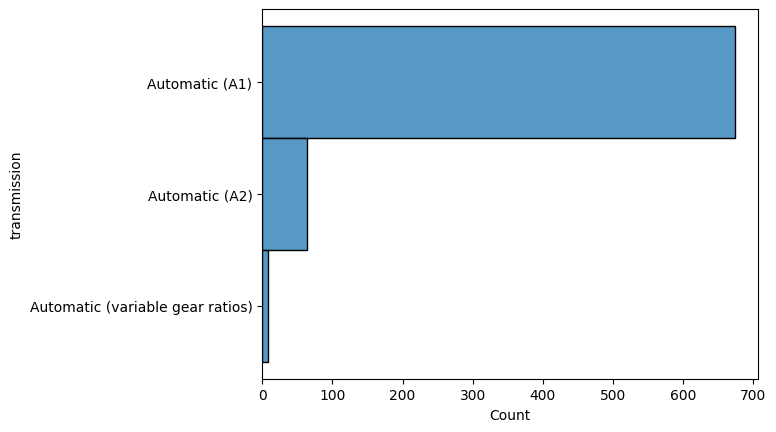

In [146]:
sns.histplot(data=veh_subdata5.query("fuel_type == 'Electricity'"), y = "transmission")

<Axes: xlabel='Count', ylabel='transmission'>

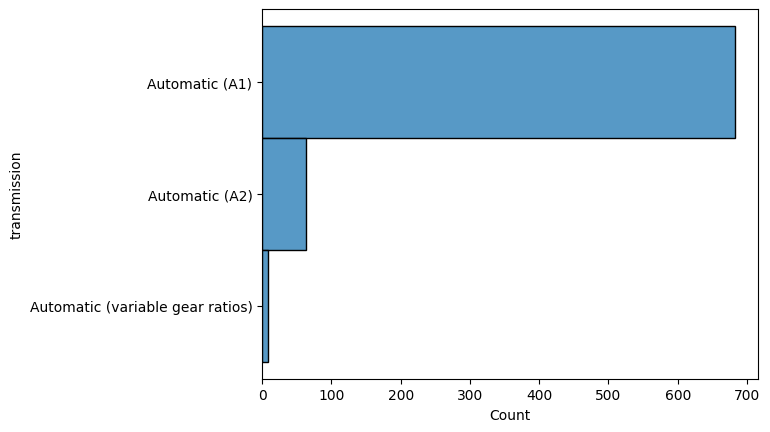

In [147]:
sns.histplot(transmission_fitted.query("fuel_type == 'Electricity'"), y = "transmission")

In [148]:
veh_subdata5.query("transmission.isna()==True")

,make,basemodel,model,year,vehicle_size_class,cylinders,engine_displacement,t_charger,s_charger,electric_motor,transmission,drive,start-stop,fuel_type,fuel_type1,fuel_type2,phev_blended,city_electricity_consumption_kwhpkm,city_kmpl_for_fuel_type1,city_kmpl_for_fuel_type2,highway_electricity_consumption_kwhpkm,highway_kmpl_for_fuel_type1,highway_kmpl_for_fuel_type2,combined_electricity_consumption_kwhpkm,combined_kmpl_for_fuel_type1,combined_kmpl_for_fuel_type2,hours_to_charge_at_120v,hours_to_charge_at_240v,co2_tailpipe_for_fuel_type1_gpkm,co2_tailpipe_for_fuel_type2_gpkm
1408,Toyota,RAV4,RAV4 EV,2002,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,50 KW DC,None,2-Wheel Drive,N,Electricity,Electricity,None,False,24.233537,30.798522,0.0,30.447264,24.426414,0.0,26.719028,27.612468,0.0,0.0,0.0,0.0,0.0
2616,Nissan,Altra EV,Altra EV,2000,Midsize Station Wagons,0.0,0.0,False,False,62 KW AC Induction,None,None,N,Electricity,Electricity,None,False,25.476282,28.674486,0.0,22.990791,32.214546,0.0,24.854909,30.090510,0.0,0.0,0.0,0.0,0.0
2617,Toyota,RAV4,RAV4 EV,2000,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,50 KW DC,None,2-Wheel Drive,N,Electricity,Electricity,None,False,25.476282,28.674486,0.0,32.932755,22.656384,0.0,29.204519,25.488432,0.0,0.0,0.0,0.0,0.0
8681,Ford,Th!nk,Th!nk,2001,Two Seaters,0.0,0.0,False,False,27 KW AC Induction,None,None,N,Electricity,Electricity,None,False,28.583146,26.196444,0.0,36.660991,20.532348,0.0,32.311382,23.010390,0.0,0.0,0.0,0.0,0.0
17938,Ford,Explorer,Explorer USPS Electric,2001,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,67 KW AC Induction,None,2-Wheel Drive,N,Electricity,Electricity,None,False,46.602955,15.930270,0.0,63.380019,11.682198,0.0,54.059428,13.806234,0.0,0.0,0.0,0.0,0.0
21370,Toyota,RAV4,RAV4 EV,2001,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,50 KW DC,None,2-Wheel Drive,N,Electricity,Electricity,None,False,25.476282,28.674486,0.0,32.932755,22.656384,0.0,29.204519,25.488432,0.0,0.0,0.0,0.0,0.0
24738,Nissan,Hyper-Mini,Hyper-Mini,2001,Two Seaters,0.0,0.0,False,False,24 KW AC Synchronous,None,None,N,Electricity,Electricity,None,False,24.854909,29.736504,0.0,31.690010,23.364396,0.0,27.961773,26.550450,0.0,0.0,0.0,0.0,0.0
29650,Toyota,RAV4,RAV4 EV,2003,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,50 KW DC,None,2-Wheel Drive,N,Electricity,Electricity,None,False,24.233537,30.798522,0.0,30.447264,24.426414,0.0,26.719028,27.612468,0.0,0.0,0.0,0.0,0.0
36994,Ford,Explorer,Explorer USPS Electric,2002,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,67 KW AC Induction,None,2-Wheel Drive,N,Electricity,Electricity,None,False,46.602955,15.930270,0.0,63.380019,11.682198,0.0,54.059428,13.806234,0.0,0.0,0.0,0.0,0.0


In [149]:
transmission_fitted.loc[index_of_transmission_na, :]

,make,basemodel,model,year,vehicle_size_class,cylinders,engine_displacement,t_charger,s_charger,electric_motor,drive,start-stop,fuel_type,fuel_type1,fuel_type2,phev_blended,transmission
17,Toyota,RAV4,RAV4 EV,2002,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,50 KW DC,2-Wheel Drive,N,Electricity,Electricity,None,False,Automatic (A1)
40,Nissan,Altra EV,Altra EV,2000,Midsize Station Wagons,0.0,0.0,False,False,62 KW AC Induction,None,N,Electricity,Electricity,None,False,Automatic (A1)
41,Toyota,RAV4,RAV4 EV,2000,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,50 KW DC,2-Wheel Drive,N,Electricity,Electricity,None,False,Automatic (A1)
138,Ford,Th!nk,Th!nk,2001,Two Seaters,0.0,0.0,False,False,27 KW AC Induction,None,N,Electricity,Electricity,None,False,Automatic (A1)
298,Ford,Explorer,Explorer USPS Electric,2001,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,67 KW AC Induction,2-Wheel Drive,N,Electricity,Electricity,None,False,Automatic (A1)
349,Toyota,RAV4,RAV4 EV,2001,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,50 KW DC,2-Wheel Drive,N,Electricity,Electricity,None,False,Automatic (A1)
400,Nissan,Hyper-Mini,Hyper-Mini,2001,Two Seaters,0.0,0.0,False,False,24 KW AC Synchronous,None,N,Electricity,Electricity,None,False,Automatic (A1)
477,Toyota,RAV4,RAV4 EV,2003,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,50 KW DC,2-Wheel Drive,N,Electricity,Electricity,None,False,Automatic (A1)
573,Ford,Explorer,Explorer USPS Electric,2002,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,67 KW AC Induction,2-Wheel Drive,N,Electricity,Electricity,None,False,Automatic (A1)


In [150]:
original_index = veh_subdata5[veh_subdata5.transmission.isna()==True].index.tolist()
veh_subdata6 = veh_subdata5.copy()
veh_subdata6.loc[original_index, "transmission"] = transmission_fitted.loc[index_of_transmission_na, "transmission"].tolist()

In [151]:
veh_subdata6.isna().sum().reset_index(drop=False).rename(columns = {"index":"cols", 0:"na_values"}).query("na_values>0")

,cols,na_values
11,drive,4
12,start-stop,13478


##### drive

In [152]:
veh_subdata6.drive.value_counts(dropna=False)

drive
Front-Wheel Drive             8841
Rear-Wheel Drive              8813
All-Wheel Drive               5447
4-Wheel or All-Wheel Drive    3194
4-Wheel Drive                 2226
Part-time 4-Wheel Drive        574
2-Wheel Drive                   12
None                             4
Name: count, dtype: int64

In [153]:
veh_subdata6.query("drive.isna()==True").fuel_type.unique()

array(['Electricity'], dtype=object)

As the missing drive values are all from electric vehicles, the same KNN imputation model will be used

In [154]:
cols_predict_drive = [
                                                "make",
                                                "basemodel",
                                                "model", 
                                                "year", 
                                                "vehicle_size_class",
                                                "cylinders", 
                                                "engine_displacement",# in liters 
                                                "t_charger", # has turbocharger (True/False)
                                                "s_charger", # has supercharger (True/False)
                                                "electric_motor",
                                                "start-stop",
                                                "fuel_type", 
                                                "fuel_type1",
                                                "fuel_type2",
                                                "phev_blended",
                                                "transmission",
                                                "drive" #traction     
                                             ]

In [155]:
drive_electric_data = veh_subdata6[cols_predict_drive].query("fuel_type=='Electricity'")

In [156]:
index_na_vals = drive_electric_data.reset_index(drop=True).query("drive.isna()==True").index

In [157]:
drive_electric_data.loc[drive_electric_data.drive.isna()==True,"drive"] = np.nan

In [158]:
encoder = preprocessing.OrdinalEncoder()
drive_electric_encoded = encoder.fit_transform(drive_electric_data)
np.isnan(drive_electric_encoded[:,-1]).sum()

np.int64(4)

In [159]:
imputer = KNNImputer()
drive_imputed = imputer.fit_transform(drive_electric_encoded) 
drive_imputed = drive_imputed.astype(int)
drive_decoded = encoder.inverse_transform(drive_imputed)
drive_decoded = pd.DataFrame(drive_decoded, columns = cols_predict_drive)

In [160]:
drive_decoded.loc[index_na_vals, :]

,make,basemodel,model,year,vehicle_size_class,cylinders,engine_displacement,t_charger,s_charger,electric_motor,start-stop,fuel_type,fuel_type1,fuel_type2,phev_blended,transmission,drive
40,Nissan,Altra EV,Altra EV,2000,Midsize Station Wagons,0.0,0.0,False,False,62 KW AC Induction,N,Electricity,Electricity,None,False,Automatic (A1),Front-Wheel Drive
138,Ford,Th!nk,Th!nk,2001,Two Seaters,0.0,0.0,False,False,27 KW AC Induction,N,Electricity,Electricity,None,False,Automatic (A1),Part-time 4-Wheel Drive
182,MINI,MiniE,MiniE,2008,Minicompact Cars,0.0,0.0,False,False,150 kW,N,Electricity,Electricity,None,False,Automatic (A1),All-Wheel Drive
400,Nissan,Hyper-Mini,Hyper-Mini,2001,Two Seaters,0.0,0.0,False,False,24 KW AC Synchronous,N,Electricity,Electricity,None,False,Automatic (A1),All-Wheel Drive


In [161]:
drive_electric_data.drive.value_counts().reset_index(drop=False)

,drive,count
0,All-Wheel Drive,387
1,Rear-Wheel Drive,154
2,Front-Wheel Drive,130
3,Part-time 4-Wheel Drive,53
4,4-Wheel Drive,19
5,2-Wheel Drive,8


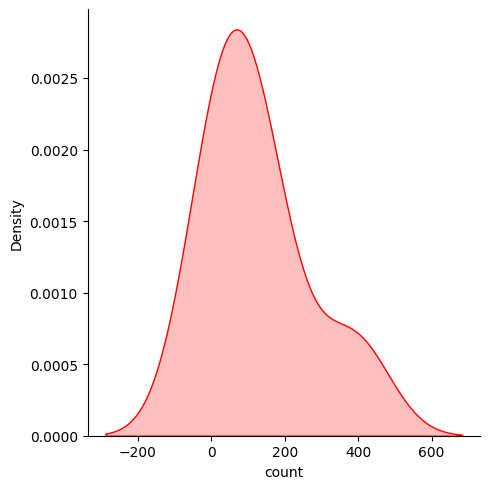

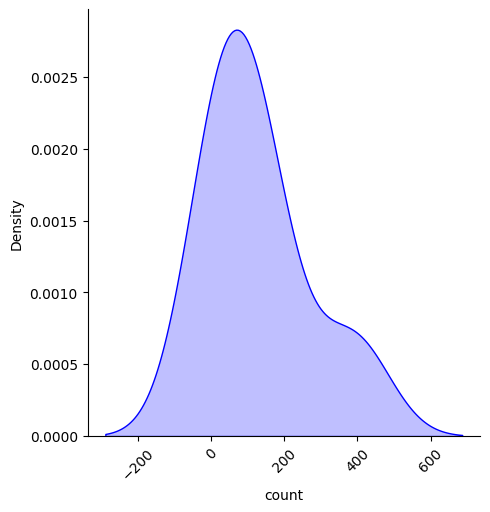

In [162]:
sns.displot(data = drive_electric_data.drive.value_counts().reset_index(drop=False), x ="count", kind = "kde", color = "red", fill = True )
sns.displot(data = drive_decoded.drive.value_counts().reset_index(drop=False), x ="count", kind = "kde", color = "blue", fill=True )
plt.xticks(rotation = 45)
plt.show()

In [163]:
veh_subdata7 = veh_subdata6.copy()
veh_subdata7.loc[veh_subdata6.drive.isna()==True,"drive"] = drive_decoded.loc[index_na_vals, "drive"].tolist()

In [164]:
veh_subdata7.isna().sum().reset_index(drop=False).rename(columns = {"index":"cols", 0:"na_values"}).query("na_values>0")

,cols,na_values
12,start-stop,13478


##### start-stop

In [165]:
veh_subdata7[veh_subdata7["start-stop"].isna()==False][["start-stop","year"]].value_counts(dropna=False, ascending=False).reset_index(drop=False)

,start-stop,year,count
0,N,2013,985
1,N,2015,971
2,N,2014,960
3,N,2016,888
4,N,2017,839
5,Y,2023,834
6,Y,2022,814
7,Y,2024,769
8,Y,2021,744
9,N,2018,722


In [166]:
veh_subdata7.loc[(veh_subdata7["start-stop"].isna()==True) | (veh_subdata7["start-stop"] == "N"), "start-stop"] = False
veh_subdata7.loc[veh_subdata7["start-stop"] == "Y", "start-stop"] = True

In [167]:
veh_subdata7["start-stop"].value_counts()

start-stop
False    22008
True      7103
Name: count, dtype: int64

### Changing column names 

In [168]:
veh_subdata7.rename(columns = {
                                "start-stop":"start_stop",
                                "engine_displacement":"engine_displacement_liters"
                               }, 
                                inplace= True)

In [169]:
veh_subdata7.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29111 entries, 0 to 47522
Data columns (total 30 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   make                                     29111 non-null  object 
 1   basemodel                                29111 non-null  object 
 2   model                                    29111 non-null  object 
 3   year                                     29111 non-null  int64  
 4   vehicle_size_class                       29111 non-null  object 
 5   cylinders                                29111 non-null  float64
 6   engine_displacement_liters               29111 non-null  float64
 7   t_charger                                29111 non-null  object 
 8   s_charger                                29111 non-null  object 
 9   electric_motor                           29111 non-null  object 
 10  transmission                             29111 non-

### Exporting Data Cleaned

In [170]:
veh_subdata7.to_parquet("../files/vehicle_data_prepared.parquet", index = False)